In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

# 1. Carregar dados
df = pd.read_excel('Vídeos Mais Assistidos do Youtube (2024).xlsx')

# 2. Limpeza e conversões
# Converter published_at para datetime
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)

# Converter duration (ISO 8601) para segundos
def iso_to_seconds(iso_str):
    # Ex: 'PT1M1S', 'PT25S', 'PT2H3M', etc.
    import re
    nums = {'H': 3600, 'M': 60, 'S': 1}
    total = 0
    for amount, unit in re.findall(r"(\d+)([HMS])", iso_str):
        total += int(amount) * nums[unit]
    return total

df['duration_sec'] = df['duration'].apply(iso_to_seconds)

# Definir métricas derivadas
# CTR aproximado: like_count / view_count
# Watch time proxy: duration_sec * view_count (tempo total assistido estimado)
df['ctr'] = df['like_count'] / df['view_count']
df['watch_time_est'] = df['duration_sec'] * df['view_count']

# 3. Estatísticas gerais
def summary_stats(series):
    return {
        'mean': series.mean(),
        'median': series.median(),
        'mode': series.mode().iloc[0] if not series.mode().empty else np.nan,
        'std': series.std(),
        '25%': series.quantile(0.25),
        '75%': series.quantile(0.75)
    }

metrics = ['view_count', 'like_count', 'comment_count', 'duration_sec', 'ctr', 'watch_time_est']
summary = {m: summary_stats(df[m]) for m in metrics}
print("\nResumo Estatístico Geral:")
for m, stats in summary.items():
    print(f"{m}: {stats}")

# 4. CTR médio por tipo de título
# Exemplo de categorização: presença de '?' no título

def categorize_title(t):
    if '?' in t:
        return 'Pergunta'
    elif len(t) > 50:
        return 'Longo'
    else:
        return 'Curto'


df['title_type'] = df['title'].apply(categorize_title)
ctr_by_type = df.groupby('title_type')['ctr'].mean()
print("\nCTR médio por tipo de título:")
print(ctr_by_type)

# 5. Watch time médio por tipo de título
wt_by_type = df.groupby('title_type')['watch_time_est'].mean()
print("\nWatch time estimado médio por tipo de título (segundos * views):")
print(wt_by_type)

# 6. Distribuição e dispersão (desvio padrão e quartis)
print("\nDistribuição e Dispersão das Métricas:")
for m in metrics:
    print(f"- {m}: Média={df[m].mean():.2f}, Desvio Padrão={df[m].std():.2f}, 25%={df[m].quantile(0.25):.2f}, 75%={df[m].quantile(0.75):.2f}")

# 7. Comparação antes/depois da introdução de IA (ex: 30/11/2022)
ai_launch = pd.to_datetime('2022-11-30T00:00:00Z')
before = df[df['published_at'] < ai_launch]
after = df[df['published_at'] >= ai_launch]

print("\nComparação antes/depois da introdução de IA (30/11/2022):")
for m in ['view_count', 'like_count', 'comment_count', 'ctr', 'watch_time_est']:
    print(f"{m}: Antes Média={before[m].mean():.2f}, Depois Média={after[m].mean():.2f}")



Resumo Estatístico Geral:
view_count: {'mean': np.float64(2012371.254817987), 'median': 508378.0, 'mode': np.int64(611258), 'std': 4269876.610005338, '25%': np.float64(169468.5), '75%': np.float64(1118840.0)}
like_count: {'mean': np.float64(71446.13062098502), 'median': 15968.0, 'mode': np.int64(3141), 'std': 153841.8477052835, '25%': np.float64(6117.5), '75%': np.float64(57812.0)}
comment_count: {'mean': np.float64(620.0620985010706), 'median': 179.0, 'mode': np.int64(0), 'std': 1433.3954325630389, '25%': np.float64(66.0), '75%': np.float64(479.0)}
duration_sec: {'mean': np.float64(515.8608137044968), 'median': 58.0, 'mode': np.int64(60), 'std': 1493.351756188094, '25%': np.float64(29.0), '75%': np.float64(254.5)}
ctr: {'mean': np.float64(0.04391104329334307), 'median': 0.03487686872746723, 'mode': np.float64(3.551798056783962e-05), 'std': 0.03339267890364581, '25%': np.float64(0.0209204400433358), '75%': np.float64(0.0552145748517439)}
watch_time_est: {'mean': np.float64(201841457.2

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime

# Carregar os dados
df = pd.read_excel("Vídeos Mais Assistidos do Youtube (2024).xlsx")

# Conversões e criação de colunas
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)

# Converter duração ISO 8601 para segundos
import re
def iso_to_seconds(iso_str):
    nums = {'H': 3600, 'M': 60, 'S': 1}
    total = 0
    for amount, unit in re.findall(r"(\d+)([HMS])", iso_str):
        total += int(amount) * nums[unit]
    return total
df['duration_sec'] = df['duration'].apply(iso_to_seconds)

# Métricas derivadas
df['ctr'] = df['like_count'] / df['view_count']
df['watch_time_est'] = df['duration_sec'] * df['view_count']

# Categorização dos títulos
def categorize_title(t):
    if '?' in t:
        return 'Pergunta'
    elif len(t) > 50:
        return 'Longo'
    else:
        return 'Curto'
df['title_type'] = df['title'].apply(categorize_title)

# Criar amostras e preparar dados para gráficos
metrics = ['view_count', 'like_count', 'comment_count', 'duration_sec', 'ctr', 'watch_time_est']
df_clean = df.dropna(subset=metrics)

df_clean.shape, df_clean.columns


((467, 10),
 Index(['title', 'published_at', 'duration', 'view_count', 'like_count',
        'comment_count', 'duration_sec', 'ctr', 'watch_time_est', 'title_type'],
       dtype='object'))

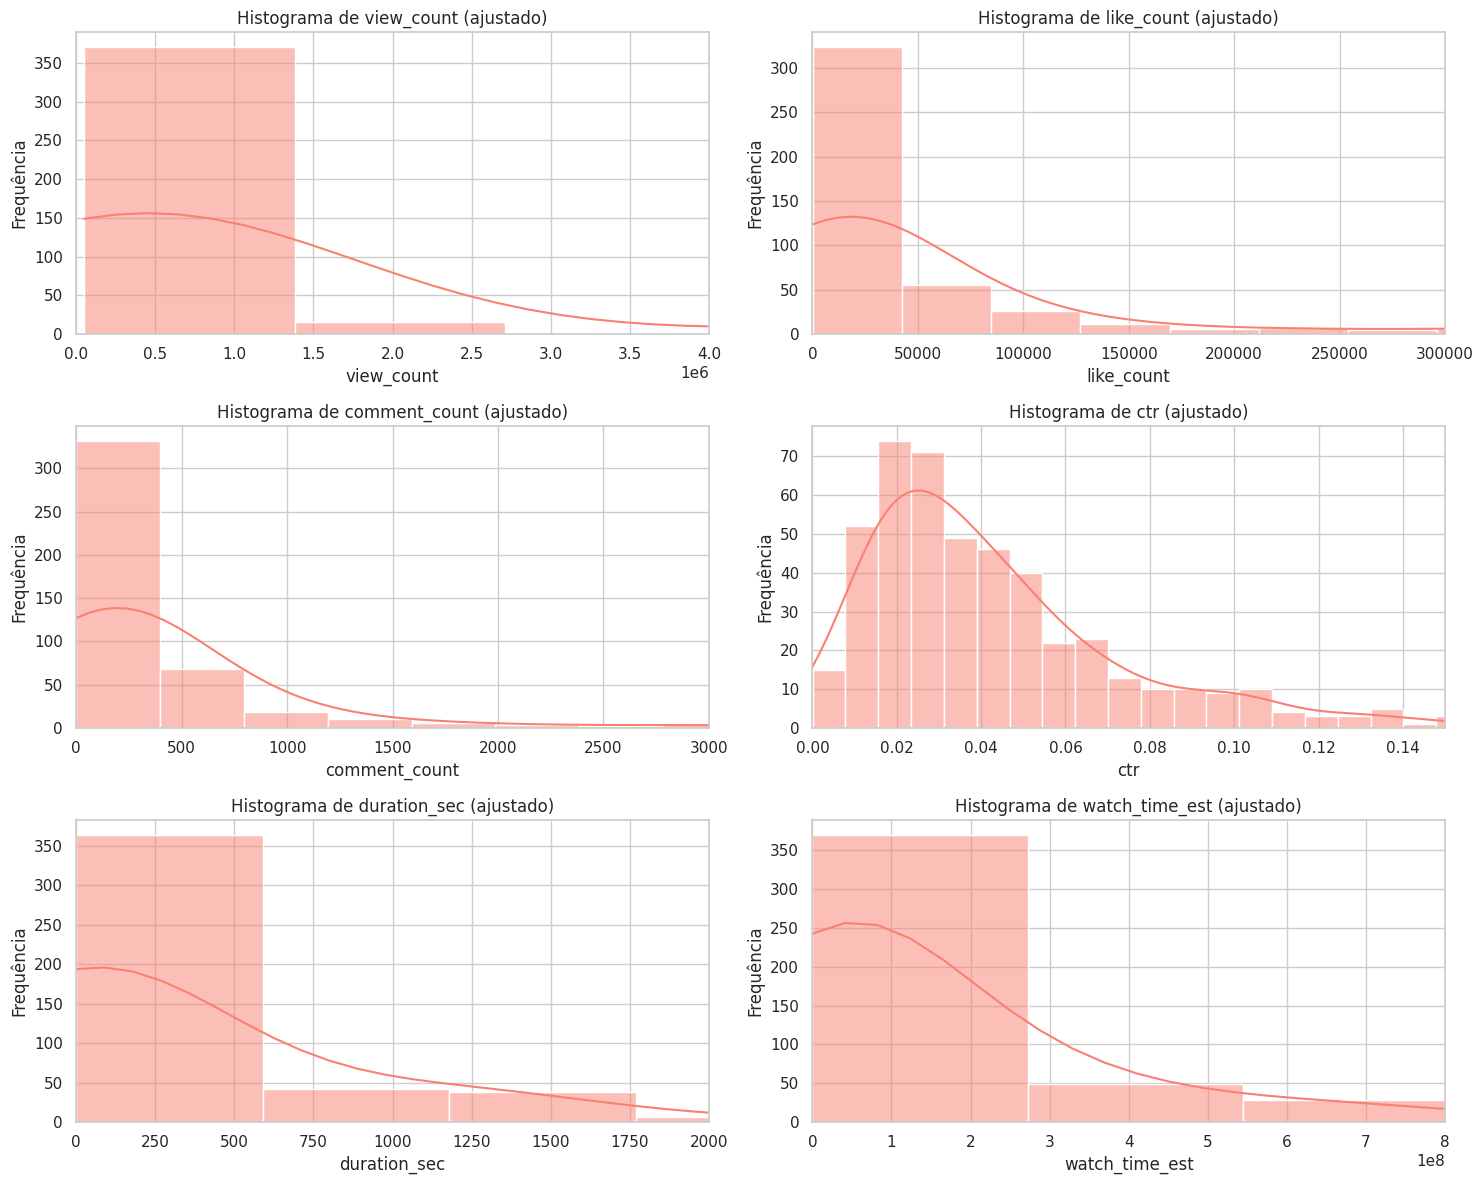

In [13]:
fig_hist, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

x_limits = {
    'view_count': (0, 4_000_000),
    'like_count': (0, 300_000),
    'comment_count': (0, 3_000),
    'ctr': (0, 0.15),
    'duration_sec': (0, 2000),
    'watch_time_est': (0, 8e8)
}

for i, metric in enumerate(['view_count', 'like_count', 'comment_count', 'ctr', 'duration_sec', 'watch_time_est']):
    sns.histplot(df[metric], kde=True, ax=axes[i], bins=30, color='salmon')
    axes[i].set_title(f'Histograma de {metric} (ajustado)')
    axes[i].set_xlabel(metric)
    axes[i].set_ylabel('Frequência')
    axes[i].set_xlim(x_limits[metric])
plt.tight_layout()
plt.show()


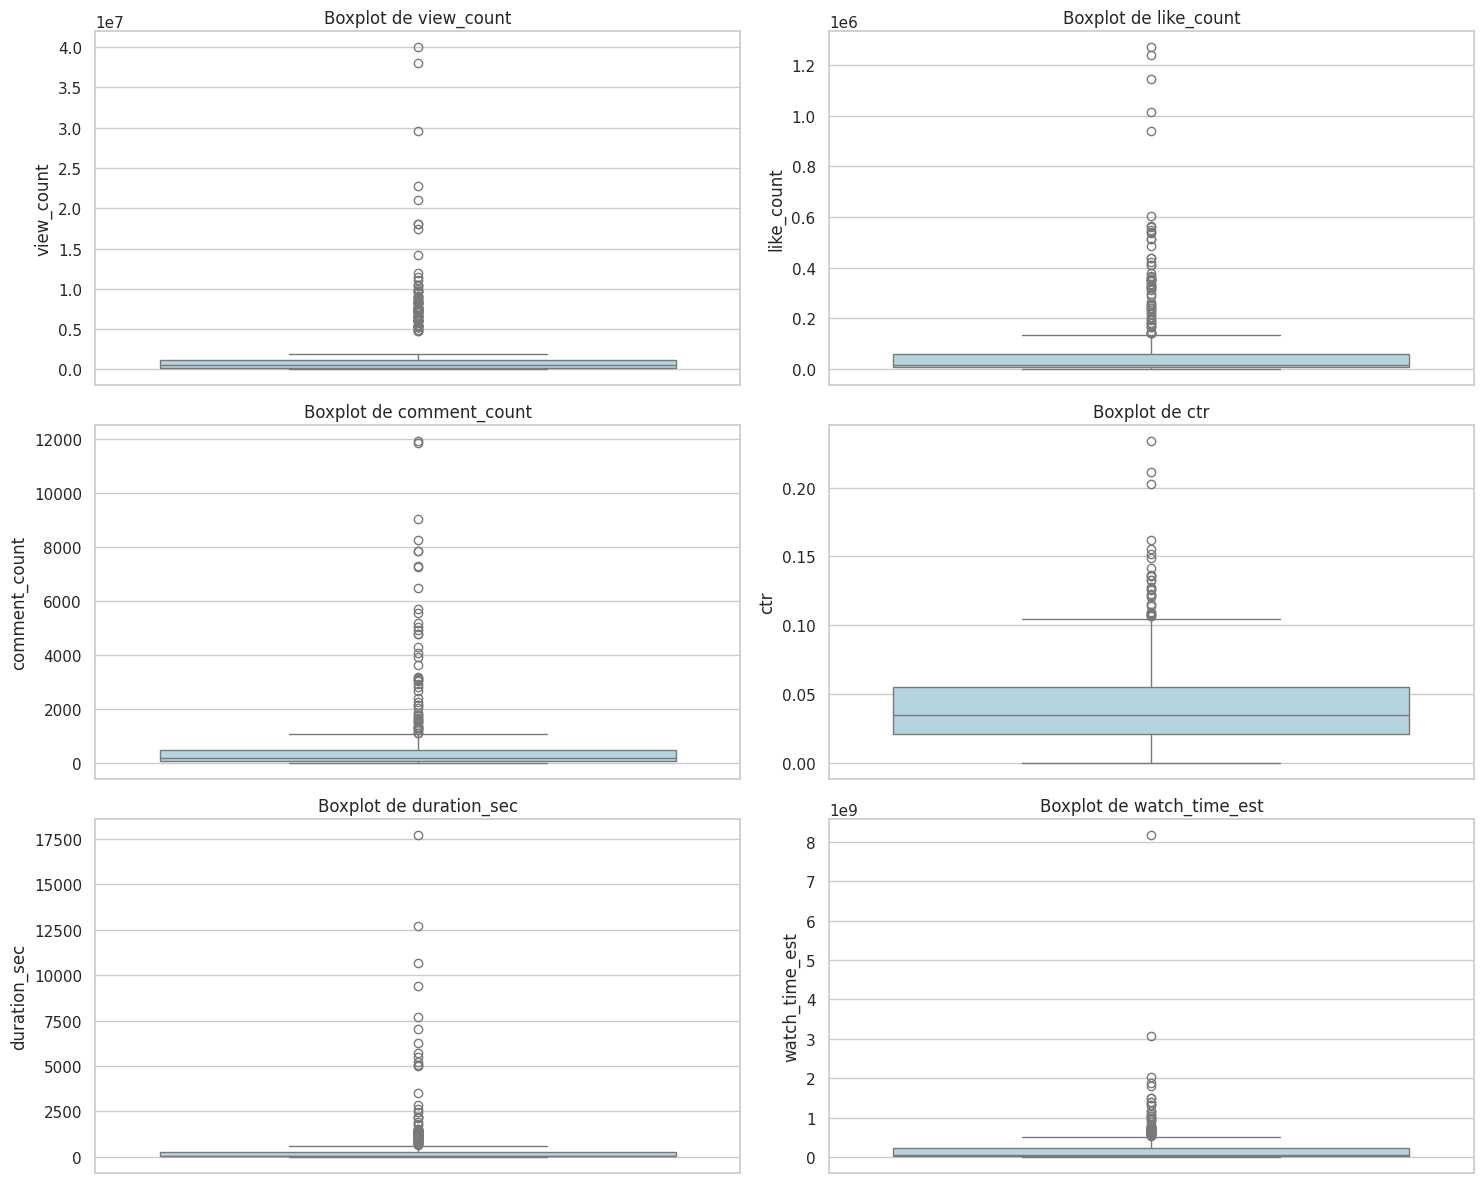

In [14]:
# Gerar boxplots para as principais métricas
fig_box, axes_box = plt.subplots(3, 2, figsize=(15, 12))
axes_box = axes_box.flatten()

for i, metric in enumerate(['view_count', 'like_count', 'comment_count', 'ctr', 'duration_sec', 'watch_time_est']):
    sns.boxplot(data=df_clean, y=metric, ax=axes_box[i], color='lightblue')
    axes_box[i].set_title(f'Boxplot de {metric}')
    axes_box[i].set_ylabel(metric)

plt.tight_layout()
plt.show()


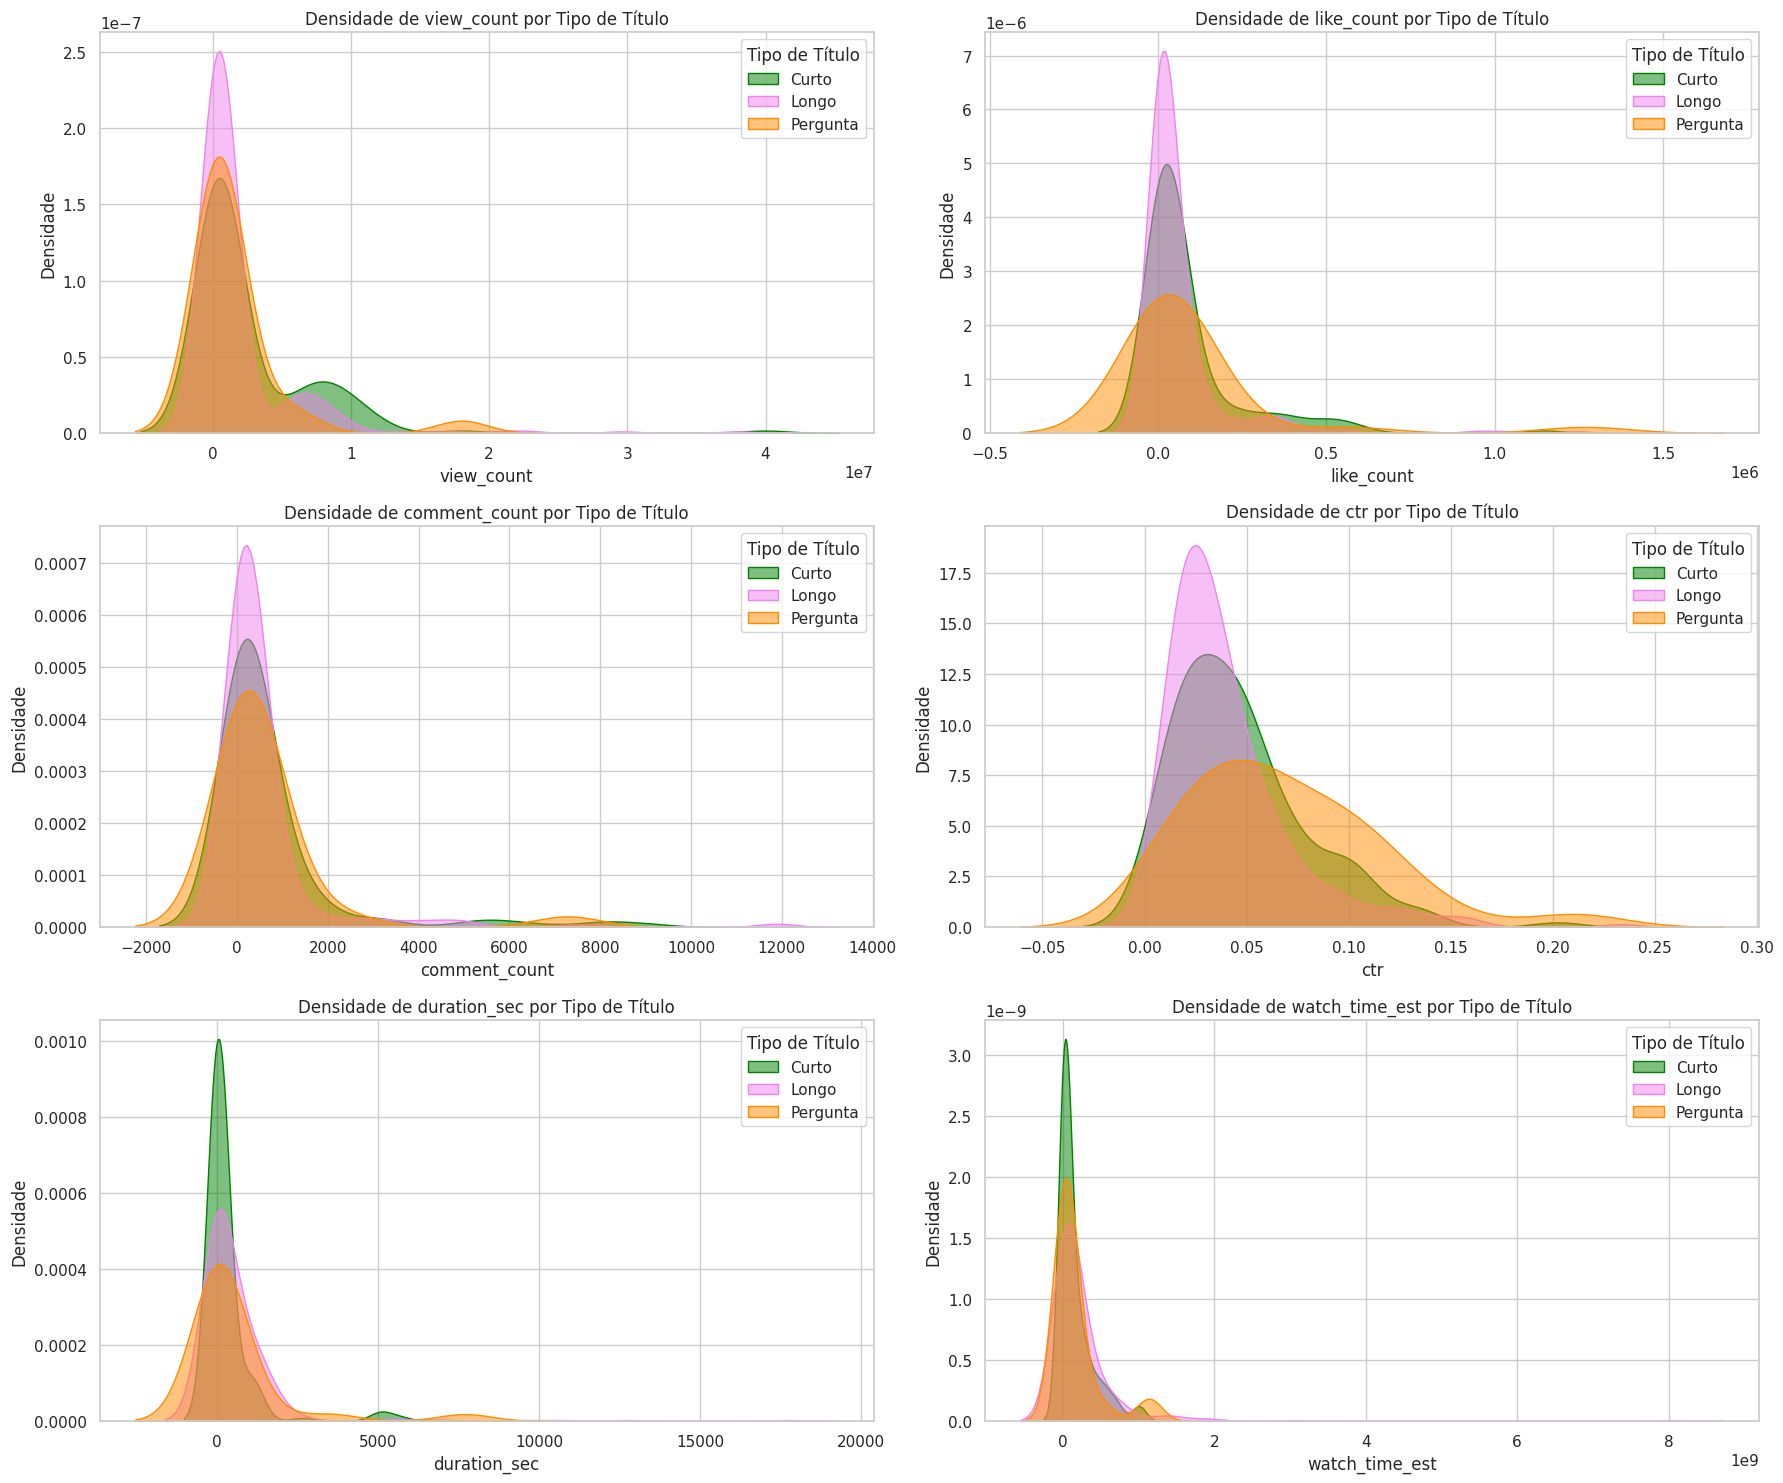

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de métricas
metrics = ['view_count', 'like_count', 'comment_count', 'ctr', 'duration_sec', 'watch_time_est']

# Cores personalizadas para cada categoria
custom_colors = {
    'Curto': 'green',
    'Longo': 'violet',  # Roxo escuro
    'Pergunta': 'darkorange'
}

# Estilo
sns.set(style="whitegrid")
plt.figure(figsize=(18, 15))

# Gerar KDEs
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    for t_type in df['title_type'].unique():
        subset = df[df['title_type'] == t_type]
        sns.kdeplot(subset[metric], label=t_type, fill=True, alpha=0.5, color=custom_colors.get(t_type, 'gray'))
    plt.title(f'Densidade de {metric} por Tipo de Título')
    plt.xlabel(metric)
    plt.ylabel('Densidade')
    plt.legend(title='Tipo de Título')

plt.tight_layout()
plt.show()


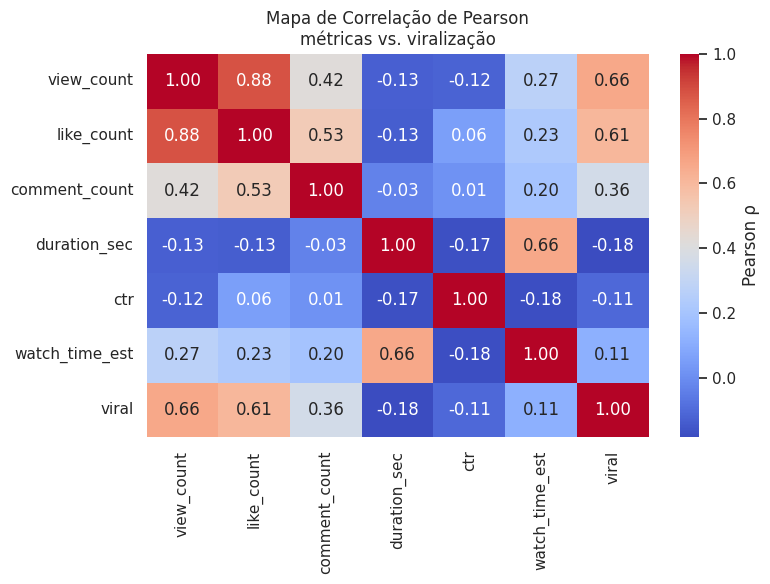

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 1. Carregar e preparar dados
df = pd.read_excel("Vídeos Mais Assistidos do Youtube (2024).xlsx")
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)

def iso_to_seconds(iso_str):
    nums = {'H':3600, 'M':60, 'S':1}
    total = 0
    for amount, unit in re.findall(r"(\d+)([HMS])", iso_str):
        total += int(amount) * nums[unit]
    return total

df['duration_sec'] = df['duration'].apply(iso_to_seconds)
df['ctr'] = df['like_count'] / df['view_count']
df['watch_time_est'] = df['duration_sec'] * df['view_count']

# 2. Definir variável viralização
threshold = df['view_count'].quantile(0.75)
df['viral'] = (df['view_count'] >= threshold).astype(int)

# 3. Selecionar as colunas de interesse
cols = ['view_count', 'like_count', 'comment_count', 'duration_sec', 'ctr', 'watch_time_est', 'viral']
corr = df[cols].corr(method='pearson')

# 4. Plotar heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Pearson ρ'})
plt.title("Mapa de Correlação de Pearson\nmétricas vs. viralização")
plt.tight_layout()
plt.show()


<ipython-input-28-a566e9c56644>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='viral', y=metric, data=df, ax=ax,
<ipython-input-28-a566e9c56644>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='viral', y=metric, data=df, ax=ax,
<ipython-input-28-a566e9c56644>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='viral', y=metric, data=df, ax=ax,
<ipython-input-28-a566e9c56644>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=

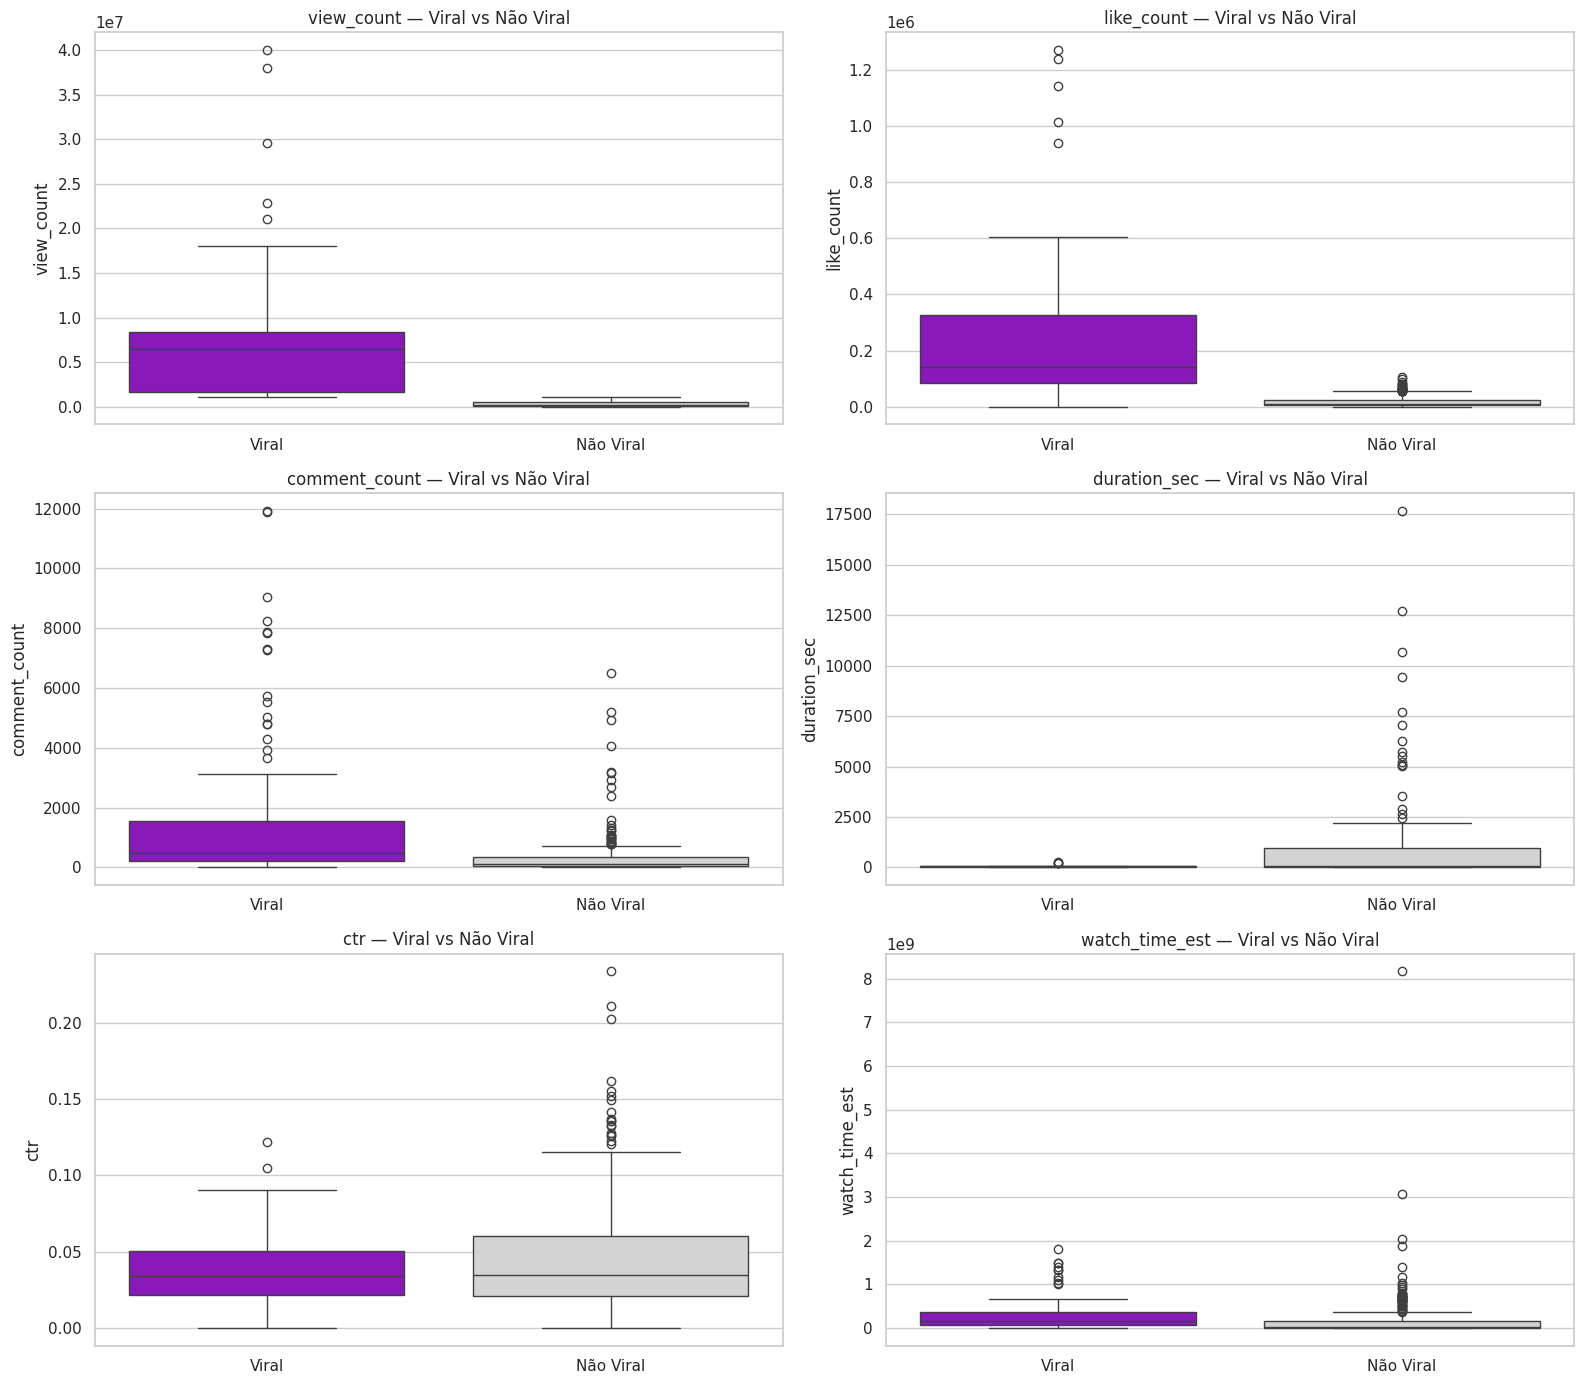

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 1. Carregar dados e preparar colunas
df = pd.read_excel("Vídeos Mais Assistidos do Youtube (2024).xlsx")
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)

# Converter duração ISO 8601 em segundos
def iso_to_seconds(iso_str):
    nums = {'H':3600, 'M':60, 'S':1}
    total = 0
    for amount, unit in re.findall(r"(\d+)([HMS])", iso_str):
        total += int(amount) * nums[unit]
    return total

df['duration_sec'] = df['duration'].apply(iso_to_seconds)
df['ctr'] = df['like_count'] / df['view_count']
df['watch_time_est'] = df['duration_sec'] * df['view_count']

# 2. Definir “viral” (top 25% de views) e “não viral”
threshold = df['view_count'].quantile(0.75)
df['viral'] = df['view_count'].ge(threshold).map({True: 'Viral', False: 'Não Viral'})

# 3. Métricas a comparar
metrics = ['view_count', 'like_count', 'comment_count', 'duration_sec', 'ctr', 'watch_time_est']

# 4. Plotar boxplots lado a lado
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    sns.boxplot(x='viral', y=metric, data=df, ax=ax,
                palette={'Viral': 'darkviolet', 'Não Viral': 'lightgray'})
    ax.set_title(f'{metric} — Viral vs Não Viral')
    ax.set_xlabel('')
    ax.set_ylabel(metric)

plt.tight_layout()
plt.show()
